In [2]:
import tensorflow as tf
import numpy as np
import glob
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import ZeroPadding2D
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [3]:
path = "../data/preprocessed_data"

# Get sorted file lists
feature_files = sorted(glob.glob(f"{path}/*_features.npy"))
target_files = sorted(glob.glob(f"{path}/*_targets.npy"))

# Generate indices and shuffle
indices = np.arange(len(feature_files))
np.random.shuffle(indices)

test_idx = indices[0]
remaining_idx = indices[1:]
train_split = int(0.85 * len(remaining_idx))
train_idx = remaining_idx[:train_split]
val_idx = remaining_idx[train_split:]


# Create datasets
train_features = [feature_files[i] for i in train_idx]
train_targets = [target_files[i] for i in train_idx]

val_features = [feature_files[i] for i in val_idx]
val_targets = [target_files[i] for i in val_idx]

test_features = [feature_files[test_idx]]
test_targets = [target_files[test_idx]]

In [ ]:
class LazyLoadDataset(tf.data.Dataset):
    def __new__(cls, input_files, target_files, batch_size=1):
        # Convert lists to TensorFlow datasets
        input_ds = tf.data.Dataset.from_tensor_slices(input_files)
        target_ds = tf.data.Dataset.from_tensor_slices(target_files)

        # Load NumPy files dynamically
        def load_numpy(input_path, target_path):
            x = np.load(input_path.numpy())
            y = np.load(target_path.numpy())
            y = y[:,:,1] # select fco2_pre

            return x, y

        def load_numpy_tf(input_path, target_path):
            # Use tf.py_function to wrap the numpy loading
            x, y = tf.py_function(load_numpy, [input_path, target_path], [tf.float32, tf.float32])

            x.set_shape([1442, 1021, 15])
            y.set_shape([1442, 1021])

            return x, y

        # Zip the datasets & apply loading function
        dataset = tf.data.Dataset.zip((input_ds, target_ds))
        dataset = dataset.map(load_numpy_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Batch, shuffle, and prefetch
        dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        return dataset

In [5]:
path = "../data/preprocessed_data"

batch_size = 2
train_dataset = LazyLoadDataset(train_features, train_targets, batch_size)
val_dataset = LazyLoadDataset(val_features, val_targets)
test_dataset = LazyLoadDataset(test_features, test_targets)


In [6]:
lr = 0.0001
loss_function = 'mse'

bias_initializer = tf.keras.initializers.Constant(270)

def build_adapted_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)


    # Bottleneck
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(b)
    u4_padded = ZeroPadding2D(((0, 0), (0, 1)))(u4)  
    u4 = layers.Concatenate()([u4_padded, c4])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u3 = layers.UpSampling2D((2, 2))(c5)
    u3_padded = ZeroPadding2D(((0, 0), (0, 1)))(u3) 
    u3 = layers.Concatenate()([u3_padded, c3])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u2 = layers.UpSampling2D((2, 2))(c6)
    u2_padded = ZeroPadding2D(((0, 1), (0, 0)))(u2) 
    u2 = layers.Concatenate()([u2_padded, c2])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    u1 = layers.UpSampling2D((2, 2))(c7)
    u1_padded = ZeroPadding2D(((0, 0), (0, 1)))(u1) 
    u1 = layers.Concatenate()([u1_padded, c1])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='linear', bias_initializer=bias_initializer)(c8)

    return Model(inputs, outputs)

# Build and compile the model
input_shape = (1442, 1021, 15)
model = build_adapted_unet(input_shape)
model.compile( loss=loss_function, metrics=['mae'],  optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

# model.summary()


In [7]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=20,  # Number of training epochs
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - loss: 28314.8672 - mae: 119.7772 - val_loss: 19934.3945 - val_mae: 123.8842
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - loss: 18423.0293 - mae: 118.4135 - val_loss: 10771.4648 - val_mae: 83.3277
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - loss: 7789.2725 - mae: 66.2883 - val_loss: 4328.4790 - val_mae: 45.6194
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - loss: 3664.8022 - mae: 40.9285 - val_loss: 2797.0122 - val_mae: 32.7846
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - loss: 2623.8015 - mae: 32.2475 - val_loss: 2380.2637 - val_mae: 29.5682
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - loss: 2288.4338 - mae: 29.6202 - val_loss: 2100.5503 - val_mae: 27.5771
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 358s 6s/step - loss: 2020.2764 - mae: 27.9040 - val_loss: 2136.6294 - val_mae: 29.7441
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - loss: 1928.7983 - mae: 27.3464 - val_loss: 1879.0250 - val_mae: 2

In [8]:
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step - loss: 1019.9014 - mae: 18.9831
Test Loss: 1019.9013671875, Test MAE: 18.98305320739746


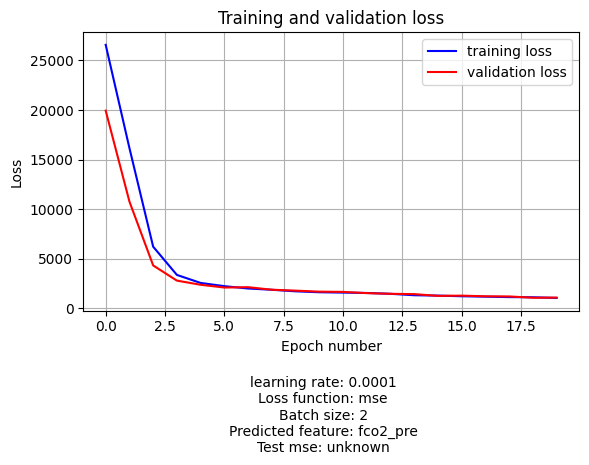

In [9]:
from datetime import datetime


plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

plt.subplots_adjust(bottom=0.3)
plt.figtext(0.5, 0.01, f"learning rate: {lr}\nLoss function: {loss_function}\nBatch size: {str(batch_size)}\nPredicted feature: fco2_pre\nTest mse: unknown",
            wrap=True, horizontalalignment='center', fontsize=10, color='black')

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
path = '../plots/u-net/' + timestamp + '_training_validation_loss.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  

In [10]:
import joblib
import plot_map

path = "../data/preprocessed_data/"
x = np.load(path + '1959_1_features.npy')
y = np.load(path + '1959_1_targets.npy')
y = y[:,:,1]

x = np.expand_dims(x, axis=0)
pred = model.predict(x)

scaler = joblib.load('scaler.pkl')
flat_x = x[0,:,:,:13].reshape(-1, 13)

denormalized_subset = scaler.inverse_transform(flat_x)
lats_longs = denormalized_subset.reshape(1442, 1021, 13)[:,:,10:12]

result = np.dstack((lats_longs, pred[0], y)).reshape(-1,4)

plot_map.plotAbsolute_numpy(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


In [ ]:
def plotPAE_numpy(data, vmin=0, vmax=10):
    # Define map boundaries
    lat_min, lat_max = -77, 90
    lon_min, lon_max = -180, 180

    # Create a grid
    num_lat, num_lon = 360, 720  # Grid resolution
    lat_grid = np.linspace(lat_min, lat_max, num_lat)
    lon_grid = np.linspace(lon_min, lon_max, num_lon)
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

    # Initialize Basemap
    m = Basemap(projection='cyl',
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180,
                resolution='c')

    # Initialize grid with NaNs (to allow masking)
    grid_values = np.full_like(lat_grid, np.nan, dtype=np.float32)

    # Map data points to the nearest grid index
    lat_idx = np.digitize(data[:, 0], lat_grid[:, 0]) - 1
    lon_idx = np.digitize(data[:, 1], lon_grid[0, :]) - 1

    # Assign values to the grid
    grid_values[lat_idx, lon_idx] = abs(data[:, 3]-data[:, 2])/data[:, 2]*100

    plt.figure(figsize=(18, 8))
    m.fillcontinents(color='black')

    # Plot data on the map
    x, y = m(lon_grid, lat_grid)
    pcm = m.pcolormesh(x, y, grid_values, vmin=vmin, vmax=vmax, cmap='coolwarm', shading='auto')
    m.fillcontinents(color='black')

    # Add colorbar
    cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
    cbar.set_label('Pre-industrial CO2 Fugacity')

    plt.title("Absolute error in percent - Pre-industrial CO2 Fugacity")
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
    path = '../plots/u-net/' + timestamp + '_pae_map.png'
    plt.savefig(path, format='png', dpi=300,  bbox_inches='tight') 
    plt.close()

In [16]:
plotPAE_numpy(result)